# Anomaly Detection using Deep Learning
This is the skeleton code file for the EE4802/IE4213 assignment. Replace the XX in the name of this Colab notebook with your group number (this is important for correct marks to be awarded to your group). Fill in the blank cells below with the necessary code (you should work on this Colab notebook section by section). At the end, the entire Colab notebook should generate all the required results and execute without error.

The text above the blank cells provide some information on the functionality that needs to be implemented. You need to write Python code at places indicated by "[WriteCode]".

In this notebook, we explore the following:

CNN, LSTM and Hybrid CNN-LSTM models

and apply the trained models to peform the following task:

Anomaly Detection: detect abnormal conditions that indicate a machine in a factory will fail in the near future, e.g. in the 24-hour period before failure.

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [26]:
# [WriteCode] import ... as ...
# [WriteCode] import ... as ...
# [WriteCode] from ... import ...
# [WriteCode] from ... import ...

# Setting seed for reproducibility (uncomment and use if needed)
# np.random.seed(xx)  
# PYTHONHASHSEED = x
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import numpy as np

## Setting up TensorBoard

In [3]:
def get_run_logdir(k):
  root_logdir = os.path.join(os.curdir, "ee4802_logs", k)
  run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
  return os.path.join(root_logdir, run_id)

## Initialize model parameters
Use the form below to enter parameter values before re-running the Colab notebook.

Use the same sequence length (seq_len), no. of epochs (ep) and batch size (ba) values for all the CNN, LSTM and Hybrid CNN-LSTM models.

*Create additional variables and fields in this form as you require.*

In [4]:
seq_len = 30 #@param {type:"number"}            # sequence length
ep =  100#@param {type:"number"}                # epochs
ba =  100#@param {type:"number"}                # batch_size
col1 = "label" #@param {type:"string"}          # label column of dataset
# [WriteCode] additional_var1 = ... #@param{type:...}

## Data Ingestion
In the following section, we ingest the sensor dataset and the fail log.

The 'sensor_data_ampl.csv' contains timestamps, 4 measurements (indicated below) and a label.
1. Voltage
2. Rotation
3. Pressure
4. Vibration

The 'fail_log.csv' contains only timestamps for the known failed events.

In [5]:
from google.colab import files
uploaded = files.upload()

Saving fail_log.csv to fail_log.csv


In [6]:
from google.colab import files
uploaded = files.upload()

Saving sensor_data_ampl.csv to sensor_data_ampl.csv


In [11]:
# Data ingestion

# read training data
read_df = pd.read_csv('sensor_data_ampl.csv')

# read fail log
fail_df = pd.read_csv('fail_log.csv')

# view first 5 lines of each file
print(read_df.head())
print(fail_df.head())
print(read_df.shape)

              datetime        volt      rotate    pressure  vibration  label
0  2015-01-01 06:00:00  151.919999  530.813578  101.788175  49.604013      0
1  2015-01-01 07:00:00  174.522001  535.523532  113.256010  41.515905      0
2  2015-01-01 08:00:00  146.912822  456.080746  107.786965  42.099694      0
3  2015-01-01 09:00:00  179.530561  503.469990  108.283817  37.847727      0
4  2015-01-01 10:00:00  180.544277  371.600611  107.553307  41.467880      0
              datetime
0  2015-02-04 06:00:00
1  2015-03-21 06:00:00
2  2015-04-05 06:00:00
3  2015-05-05 06:00:00
4  2015-05-20 06:00:00
(8761, 6)


## Data Exploration
Understanding the underlying characteristics of the dataset

Plot sensor measurement and observe the data characteristics especially when fail events happens. (code provided)

(note: use the results provided to answer Q1 in section 7.1 of assignment file)

In [12]:
# Convert 'datetime' column to timestamp data type
read_df['datetime'] = pd.to_datetime(read_df['datetime'])
fail_df['datetime'] = pd.to_datetime(fail_df['datetime'])

In [16]:
# Define a function to plot sensor data and highlight failure events
def plot_sensor_measurement(data,fail_truth,fail_pred=None,threshold=0.3,seq_len=0):
    """
    :param data:       sensor measurements, pd df
    :param fail_truth: true fail log, pd df
    :param fail_pred:  prediction made by trained models
    :param threshold:  predicted output >= threshold --> 1 (anomaly)
    :param seq_len:  sequence length
    :return:           Plot
    """

    fig, ax = plt.subplots(figsize=(20,10))

    # plot sensor data
    ax.plot(data['datetime'], data['volt'], color='b', label='volt')
    ax.plot(data['datetime'], data['rotate'], color='g', label='rotate')
    ax.plot(data['datetime'], data['pressure'], color='m', label='pressure')
    ax.plot(data['datetime'], data['vibration'], color='y', label='vibration')

    # plot predicted failures
    if type(fail_pred) != type(None):
        # Extract predicted anomalies
        fail_pred = pd.DataFrame(fail_pred, columns=['pred'])
        fail_pred['pred_label'] = np.where(fail_pred['pred']>=threshold,1,0)
        fail_pred['datetime'] = data['datetime'].iloc[seq_len:].reset_index(drop=True)
        fail_pred = fail_pred.loc[fail_pred['pred_label']==1].reset_index(drop=True)

        if fail_pred.empty:
            print('Empty predicted failure data, consider adjust threshold value!')
        else:
            # fail_pred['datetime'] = fail_pred['datetime'] # + timedelta(hours=seq_len)
            # plot predicted anomalies
            ax.axvline(x=fail_pred['datetime'][0], color='c', label='predicted failure events', linestyle = '--')
            for dt in fail_pred['datetime'][1:]:
                ax.axvline(x=dt, color='c', linestyle = '--')

    # plot failure events
    ax.axvline(x=fail_truth['datetime'][0], color='r', label='failure events')
    for df in fail_truth['datetime'][1:]:
        ax.axvline(x=df, color='r')

    # Format X axis
    ax.xaxis.set_major_formatter(DateFormatter("%b"))

    plt.title('Sensor Measurement', fontsize=26)
    plt.xticks(fontsize = 16)
    plt.yticks(fontsize = 16)
    plt.xlabel("date", fontsize = 22)
    plt.ylabel("measurement", fontsize = 22)
    plt.grid(True)
    plt.legend(fontsize = 16, bbox_to_anchor=(1, 1))

    plt.show()

### Data Plotting: Original Data

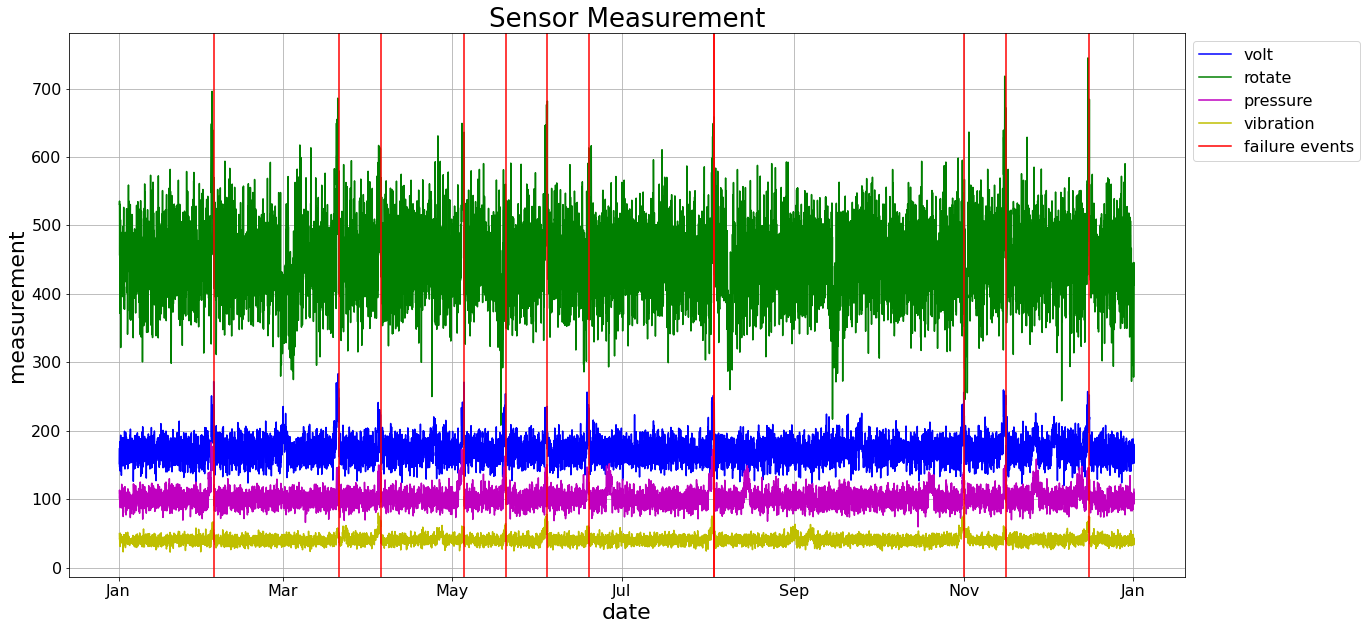

In [23]:
plot_sensor_measurement(read_df, fail_df)

### Sliding Window

Sensor measurements from machines can be noisy! We can hardly tell anything from the plot above. One popular method to remove the noise is to apply a sliding averaging window through time. Let us apply it to the voltage measurements in April and compare the sensor measurements.

In [24]:
# Helper function to plot sensor measurements
def plot_sensor(data_df, col, title):
    fig, ax =  plt.subplots(figsize=(20,6))

    # Plot may_data
    ax.plot(data_df['datetime'], data_df[col], color='g', label='volt')

    # Format x axis
    ax.xaxis.set_major_formatter(DateFormatter("%b %d"))

    plt.title(title, fontsize = 26)
    plt.xticks(fontsize = 16)
    plt.yticks(fontsize = 16)
    plt.xlabel("date", fontsize = 22)
    plt.ylabel("volt", fontsize = 22)
    plt.grid(True)
    plt.legend(fontsize = 16, bbox_to_anchor=(1, 1))

    plt.show()

Compute the sliding window average of 10 readings:

In [27]:
# Extract April data
apr_data = (read_df.loc[read_df['datetime'].dt.month==4]).reset_index(drop=True)

# Compute sliding average of 10 readings
avg_win_size = 10
apr_data = apr_data.sort_values(by='datetime', ascending=True)
apr_data['avg'] = np.nan
for i in range(len(apr_data)-avg_win_size):
    apr_data.loc[i + avg_win_size-1, ['avg']] = apr_data['volt'][i:i+avg_win_size].mean()

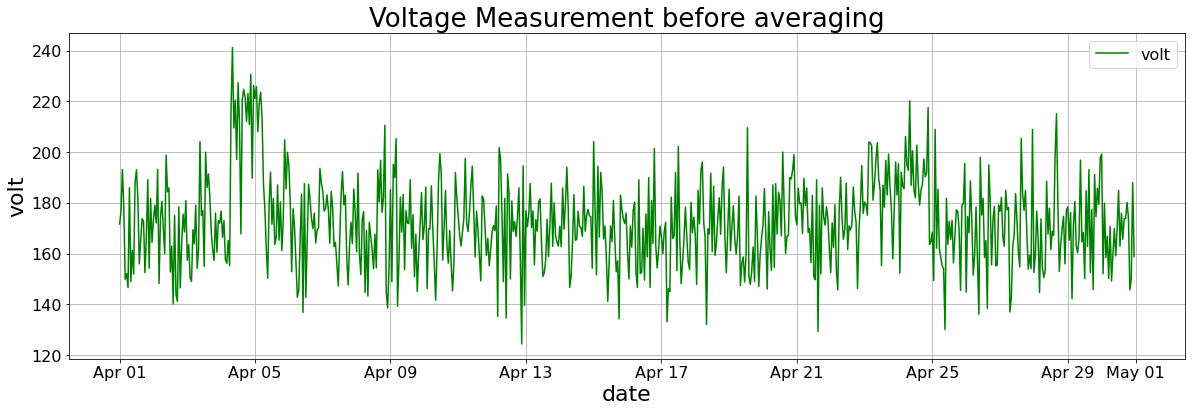

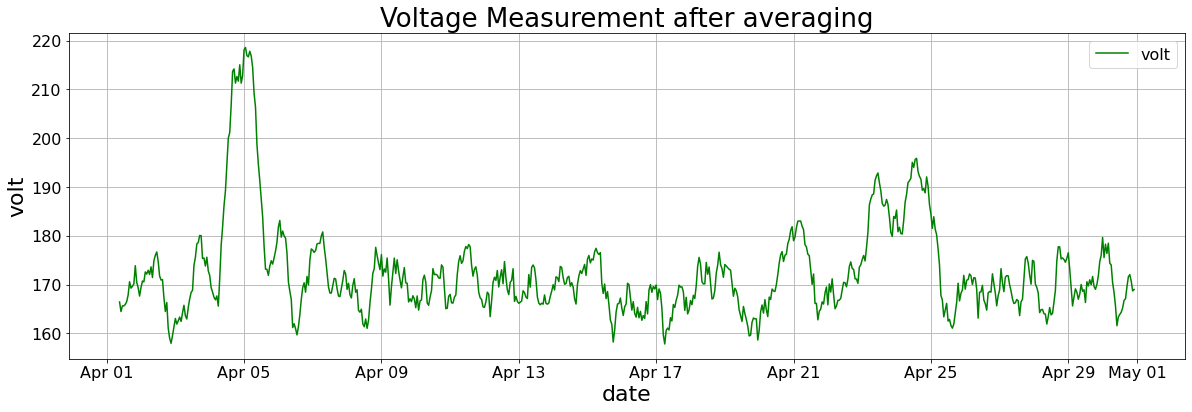

In [28]:
# Plot the sensor measurements before/after averaging:
plot_sensor(apr_data, 'volt', 'Voltage Measurement before averaging')
plot_sensor(apr_data,'avg', 'Voltage Measurement after averaging')

### Data Plotting: Sliding Window Averaged Data
Now, the sensor readings are less noisy and clearer trends can be observed. Let us apply averaging to all four sensor measurements and plot them against the failure events.

(note: Compare the plot before and after averaging and answer the question in Section 7.1 of the Assignment document)

In [30]:
def sliding_avg(data, win_size, step_size=1):
    data_dict = {}
    for col_name in data.columns:
        data_dict[col_name] = []
    for col_name in data.columns:
        i = 0
        while i < (len(data)-win_size):
            if col_name == 'datetime':
                data_dict[col_name].append(data[col_name][i+win_size-1])
            else:
                data_dict[col_name].append(data[col_name][i:i+win_size].mean())
            i += step_size

    return pd.DataFrame(data_dict)

In [31]:
# Define averaging parameters
sliding_window_width = 10
sliding_step_size = 5

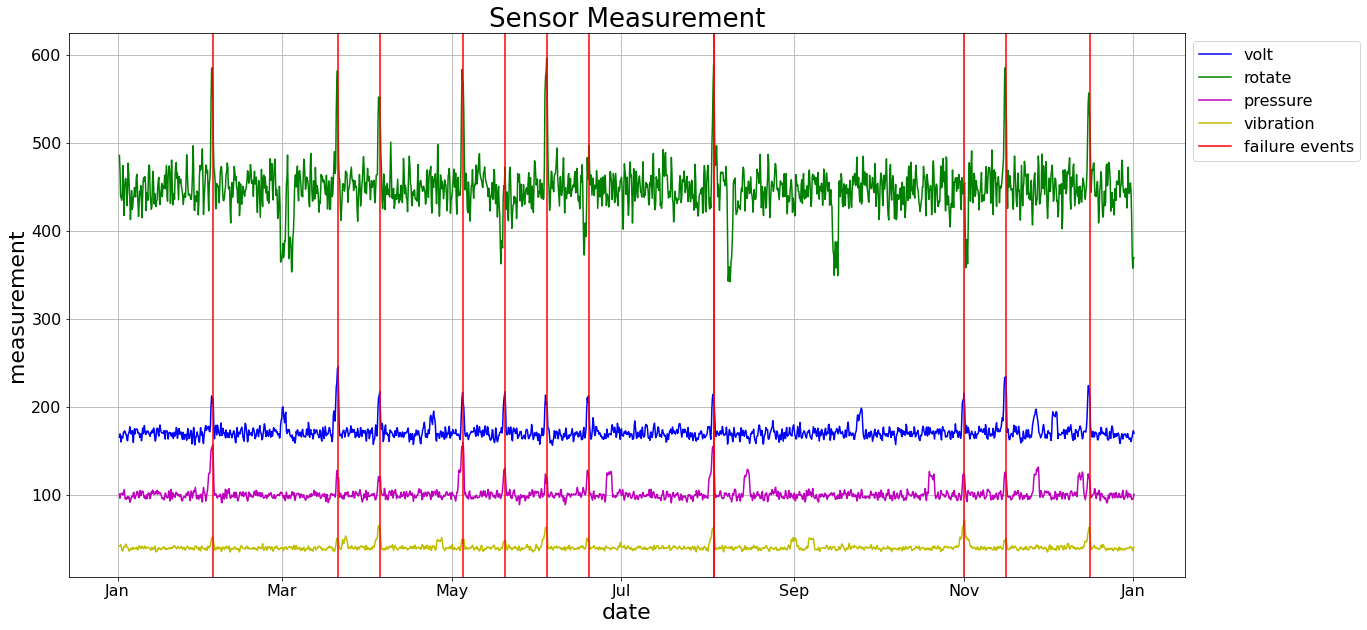

In [32]:
slide_avg_df = sliding_avg(read_df, sliding_window_width, sliding_step_size)
plot_sensor_measurement(slide_avg_df, fail_df)

In [38]:
print(slide_avg_df.shape)
slide_avg_df.head()

(1751, 6)


,datetime,volt,rotate,pressure,vibration,label
0,2015-01-01 15:00:00,166.213742,486.221155,101.513046,42.543338,0.0
1,2015-01-01 20:00:00,169.901607,468.869818,96.772993,42.779903,0.0
2,2015-01-02 01:00:00,165.758859,440.072080,100.992027,43.970783,0.0
3,2015-01-02 06:00:00,160.619918,437.748592,102.084277,42.328265,0.0
4,2015-01-02 11:00:00,167.204666,435.249720,102.073473,39.490542,0.0



## Data Preprocessing

### Data Labeling

The sensor data file has a column "label" which has a value '1' to indicate that the sensor measurements are abnormal 24 hours before a failure occurs.

(note: Column names are case-sensitive in Pandas)

### Data Normalization
Noticed that the values of sensor measurements comes with different ranges. To help the models to learn better, perform min-max normalization using the MinMax scaler in sklearn on slide_avg_df.

**Make your normalized sensor data  variable name 'slide_avg_norm_df'.**

In [43]:
# MinMax normalization for training data

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
slide_avg_norm_df_sc=scaler.fit_transform(slide_avg_df[['volt','rotate','pressure','vibration']])
slide_avg_norm_df=slide_avg_df
slide_avg_norm_df['volt']=slide_avg_norm_df_sc[:,0]
slide_avg_norm_df['rotate']=slide_avg_norm_df_sc[:,1]
slide_avg_norm_df['pressure']=slide_avg_norm_df_sc[:,2]
slide_avg_norm_df['vibration']=slide_avg_norm_df_sc[:,3]

In [44]:
# Examine the data
# The label column has value '1' to indicate the anomalous sensor readings before each failure.
# e.g. 2015-02-04 06:00:00 is a logged failure event
slide_avg_norm_df.loc[150:165,:]

,datetime,volt,rotate,pressure,vibration,label
150,2015-02-01 21:00:00,0.191027,0.517412,0.113802,0.068215,0.0
151,2015-02-02 02:00:00,0.235084,0.485859,0.182037,0.052963,0.0
152,2015-02-02 07:00:00,0.214631,0.496161,0.227463,0.169640,0.0
153,2015-02-02 12:00:00,0.212043,0.395028,0.366950,0.177892,0.0
154,2015-02-02 17:00:00,0.241912,0.316900,0.492953,0.118540,0.0
155,2015-02-02 22:00:00,0.177645,0.439208,0.507944,0.151909,0.0
156,2015-02-03 03:00:00,0.172881,0.459518,0.507180,0.185507,0.0
157,2015-02-03 08:00:00,0.247094,0.517099,0.678604,0.183623,0.2
158,2015-02-03 13:00:00,0.503771,0.799097,0.876467,0.335670,0.7
159,2015-02-03 18:00:00,0.627492,0.951060,0.900494,0.447263,1.0


### Split Training data

In [45]:
# We will be using data from 2015-Jan to 2015-Jun as the training set
# and all the data as the test set (see comment in Assignment document)

# training and test set for training/evaluation
train_df = slide_avg_norm_df[slide_avg_norm_df.datetime < '2015-07-01 00:00:00'].reset_index(drop=True)
test_df = slide_avg_norm_df

# Slice the slide_avg_norm_df and fail_df into two parts
slide_avg_train_df = slide_avg_df[slide_avg_df.datetime < '2015-07-01 00:00:00'].reset_index(drop=True)
slide_avg_test_df = slide_avg_df

fail_train_df = fail_df[fail_df.datetime < '2015-07-01 00:00:00'].reset_index(drop=True)
fail_test_df = fail_df

### Generate Sequences

Any deep learning model requires two data arrays for model training. The first array is the input sequence array X (named "seq_arr_train" in this skeleton file) which contains the input features. The second array is the desired target array Y (named "label_arr_train" in this skeleton file) which contains the label or target values.

In addition, Keras layers expect the input "seq_arr_train" to be in the shape of a numpy array of 3 dimensions:

 **(no. of samples, time steps, features)**

where samples is the number of training sequences, time steps is the look back window sequence length and features is the number of features at each time step.

In this section, train2_df and test2_df are used to generate seq_arr_train and seq_arr_test respectively. label_arr_train and label_arr_test generation is done separately.

#### Generate Training Sequence Array

In [46]:
# function to reshape features into seq_array: (samples, time steps, features)
def gen_sequence(df, seq_length, seq_cols):
    data_array = df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

# pick the feature columns
sequence_cols = ['volt', 'rotate', 'pressure', 'vibration']

# generator for the training sequences
seq_gen = (list(gen_sequence(train_df, seq_len, sequence_cols)))

# generate sequences and convert to numpy array
seq_arr_train = np.stack(list(seq_gen)).astype(np.float32)

# final seq_array which is X input to CNN/LSTM for TRAINING
print(seq_arr_train.shape)

(836, 30, 4)


#### Generate Test Sequence Array

In [47]:
# generator for the training sequences
seq_gen = (list(gen_sequence(test_df, seq_len, sequence_cols)))

# generate sequences and convert to numpy array
seq_arr_test = np.stack(list(seq_gen)).astype(np.float32)

# final seq_array which is X input to CNN/LSTM for TESTING
print(seq_arr_test.shape)

(1721, 30, 4)


### Generate Label for Sequence


#### Generate Training Data Label Sequence Array

In [48]:
# function to generate label_array
def gen_labels(df, seq_length, label):
    data_array = df[label].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[stop, :]

# generate labels
label_gen = gen_labels(train_df, seq_len, ['label'])

label_arr_train = np.stack(label_gen).astype(np.float32)
label_arr_train[label_arr_train>=0.75]=1
label_arr_train[label_arr_train<0.75]=0

# final label_arr_train which is Y target output to CNN/LSTM for TRAINING
print(label_arr_train.shape)

(836, 1)


/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


In [49]:
sum(label_arr_train)

array([21.], dtype=float32)

In [50]:
label_arr_train[120:135,:]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.]], dtype=float32)

#### Generate Test Data Label Sequence Array

In [51]:
# generate labels
label_gen = gen_labels(test_df, seq_len, ['label'])

label_arr_test = np.stack(label_gen).astype(np.float32)
label_arr_test[label_arr_test>=0.75]=1
label_arr_test[label_arr_test<0.75]=0

# final label_arr_test which is Y target output to CNN/LSTM for TESTING
print(label_arr_test.shape)

(1721, 1)


/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


## CNN Model

In this section, build a CNN network (Conv1D or Conv2D). The choice of architecture - no. of layers, type of layers (convolution, pooling etc.) and nodes per layer - is up to you. 

Please include the following:

- name the model as "model_cnn"
- dropout layer after each CNN layer (drop probability of choice)
- output dense layer with ?? node(s) and ?? activation
- appropriate loss function, appropriate optimizer and "accuracy" as metric
- print the model summary

Be careful with the input shape of the model.

In [ ]:
# [WriteCode]

### Model Training

Fit the model on seq_arr_train and label_arr_train with epochs, batch_size set according to the parameter values mentioned in the beginning. Use validation_split = 0.1

Use callback: "keras.callbacks.TensorBoard(log_dir=get_run_logdir("run_cnn") , histogram_freq=1, write_graph= True, update_freq='epoch')" to store the model training to tensorboard log file "run_cnn" for visualization.

In [ ]:
%%time
cb = keras.callbacks.TensorBoard(log_dir= get_run_logdir("run_cnn_bin"), histogram_freq=1, write_graph= True, update_freq='epoch')

# [WriteCode with verbose=1]

### Training data Prediction

Generate predictions using the model on the training data.

In [ ]:
# [WriteCode]

### Predicted result plotting and effect of threshold

Usually, for a binary classification task, we threshold the predicted values at 0.5 to arrive at the classification decision. However, with an imbalanced dataset, 0.5 may not be an ideal choice. Make use of the plot and training data performance metrics below to determine a good threshold value. 

**Note that the threshold value must not be changed when evaluating the performance on test data.**

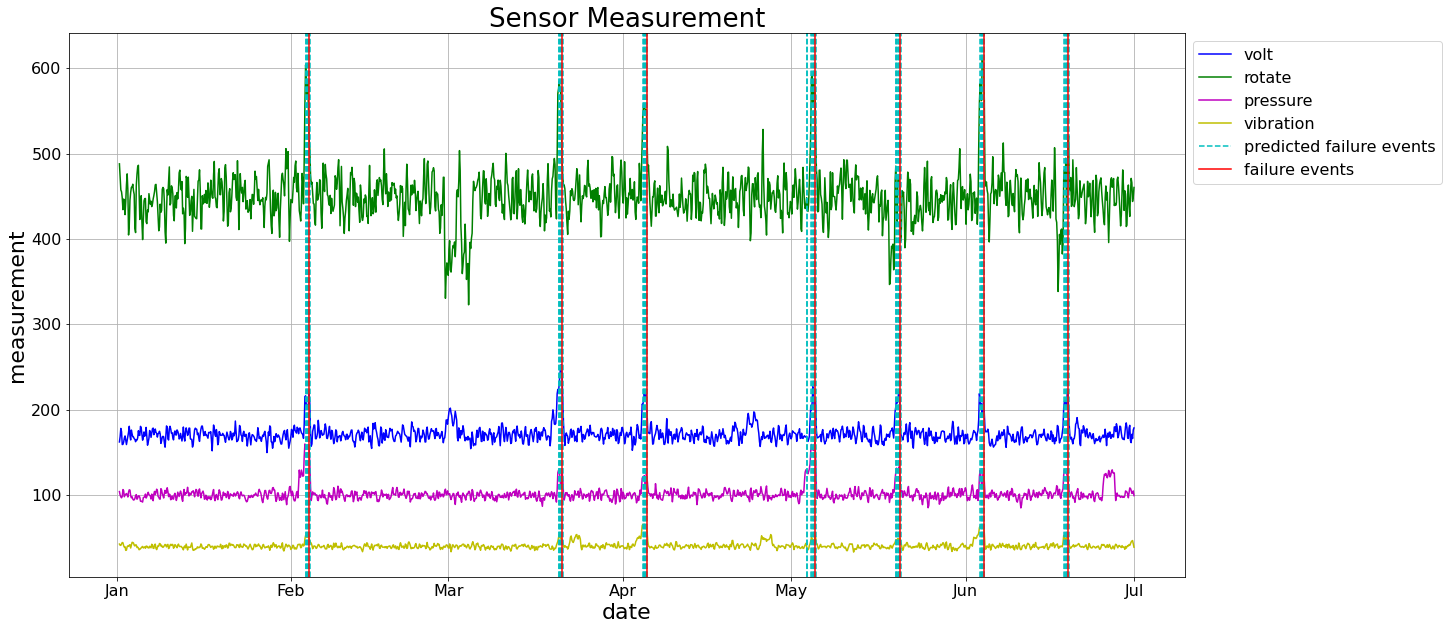

In [ ]:
# Determine a good threshold value th

plot_sensor_measurement(slide_avg_train_df, fail_train_df, cnn_train_pred, th, seq_len)

### Training data performance metrics

- Determine the accuracy of prediction of the trained model on the training data
- Print the confusion matrix for training data prediction
- Print precision, recall and F-score for training data prediction

In [ ]:
# [WriteCode]

### Test data Prediction

Generate predictions using the model on the test data.

In [ ]:
# [WriteCode]

### Predicted result plotting

In [ ]:
plot_sensor_measurement(slide_avg_test_df, fail_test_df, cnn_pred, th, seq_len)

### Test data performance metrics

- Determine the accuracy of prediction of the trained model on the test data
- Print the confusion matrix for test data prediction
- Print precision, recall and F-score for test data prediction

In [ ]:
# [WriteCode]

## LSTM Model
In this section, build a LSTM network. The choice of architecture - no. of layers, type of layers, and nodes per layer - is up to you. 

Please include the following:
- name the model as "model_lstm"
- dropout layer after each LSTM layer (drop probability of choice)
- output dense layer with ?? node(s) and ?? activation
- appropriate loss function, appropriate optimizer and "accuracy" as metric
- print the model summary

Be careful with the input shape of the model.


In [ ]:
# [WriteCode]

### Model Training

Fit the model on seq_arr_train and label_arr_train with epochs, batch_size set according to the parameter values mentioned in the beginning. Use validation_split = 0.1

Use callback: "keras.callbacks.TensorBoard(log_dir=get_run_logdir("run_lstm") , histogram_freq=1, write_graph= True, update_freq='epoch')" to store the model training to tensorboard log file "run_lstm" for visualization.

In [ ]:
%%time
cb = keras.callbacks.TensorBoard(log_dir= get_run_logdir("run_lstm"), histogram_freq=1, write_graph= True, update_freq='epoch')

# [WriteCode with verbose=1]

### Training data Prediction

Generate predictions using the model on the training data.

In [ ]:
# [WriteCode]

### Predicted result plotting and effect of threshold

Usually, for a binary classification task, we threshold the predicted values at 0.5 to arrive at the classification decision. However, with an imbalanced dataset, 0.5 may not be an ideal choice. Make use of the plot and training data performance metrics below to determine a good threshold value. 

**Note that the threshold value must not be changed when evaluating the performance on test data.**

In [ ]:
# Determine a good threshold value th

plot_sensor_measurement(slide_avg_train_df, fail_train_df, lstm_train_pred, th, seq_len)

### Training data performance metrics

- Determine the accuracy of prediction of the trained model on the training data
- Print the confusion matrix for training data prediction
- Print precision, recall and F-score for training data prediction

In [ ]:
# [WriteCode]

### Test data Prediction

Generate predictions using the model on the test data.

In [ ]:
# [WriteCode]

### Predicted result plotting

In [ ]:
plot_sensor_measurement(slide_avg_test_df, fail_test_df, lstm_pred, th, seq_len)

### Test data performance metrics

- Determine the accuracy of prediction of the trained model on the test data
- Print the confusion matrix for test data prediction
- Print precision, recall and F-score for test data prediction

In [ ]:
# [WriteCode]

## Hybrid CNN-LSTM Model

The above CNN model and LSTM model each has certain advantages. Let us combine them to try to get the best of both.

The resulting hybrid CNN-LSTM models are quite popular in recent years. 

We can achieve this by wrapping the entire CNN input model (one layer or more) in a **TimeDistributed layer**. This layer achieves the desired outcome of applying the same layer or layers multiple times. 



In our case, we wish to apply the same CNN layers multiple times to multiple input time steps and in turn providing a sequence of “sensor measurement features” to the LSTM model to work on.

In this section build a Hybrid CNN - LSTM network. The choice of architecture - no. of layers, type of layers (CNN, pooling etc.) and nodes per layer - is up to you. 

Please include the following:
- name the model as "model_cnn_lstm" 
- dropout layer after each CNN and LSTM layer (drop probability of choice)
- output dense layer with ?? node(s) and ?? activation
- appropriate loss function, appropriate optimizer and "accuracy" as metric
- print the model summary 

Be careful with the input shape of the model.


In [ ]:
# [WriteCode]

### Model Training

Fit the model on seq_arr_train and label_arr_train with epochs, batch_size set according to the parameter values mentioned in the beginning. Use validation_split = 0.1

**Note: Hybrid CNN-LSTM may require more epochs of training compared to CNN and LSTM. You may increase the epochs for Hybrid CNN-LSTM if necessary.**

Use callback: "keras.callbacks.TensorBoard(log_dir=get_run_logdir("run_cnn_lstm") , histogram_freq=1, write_graph= True, update_freq='epoch')" to store the model training to tensorboard log file "run_cnn_lstm" for visualization.

In [ ]:
%%time
cb = keras.callbacks.TensorBoard(log_dir= get_run_logdir("run_cnn_lstm"), histogram_freq=1, write_graph= True, update_freq='epoch')

# [WriteCode with verbose=1]

### Training data Prediction

Generate predictions using the model on the training data.

In [ ]:
# [WriteCode]

### Predicted result plotting and effect of threshold

Usually, for a binary classification task, we threshold the predicted values at 0.5 to arrive at the classification decision. However, with an imbalanced dataset, 0.5 may not be an ideal choice. Make use of the plot and training data performance metrics below to determine a good threshold value. 

**Note that the threshold value must not be changed when evaluating the performance on test data.**

In [ ]:
# Determine a good threshold value th

plot_sensor_measurement(slide_avg_train_df, fail_train_df, hybrid_train_pred, th, seq_len)

### Training data performance metrics


- Determine the accuracy of prediction of the trained model on the training data
- Print the confusion matrix for training data prediction
- Print precision, recall and F-score for training data prediction

In [ ]:
# [WriteCode]

### Test data Prediction

Generate predictions using the model on the test data.

In [ ]:
# [WriteCode]

### Predicted result plotting

In [ ]:
plot_sensor_measurement(slide_avg_test_df, fail_test_df, hybrid_pred, th, seq_len)

### Test data performance metrics

- Determine the accuracy of prediction of the trained model on the test data
- Print the confusion matrix for test data prediction
- Print precision, recall and F-score for test data prediction

In [ ]:
# [WriteCode]

## Comparing CNN, LSTM and Hybrid CNN-LSTM models

Combine the results obtained above and print a table of accuracy, precision, recall and F-score for test data  of CNN, LSTM, Hybrid CNN-LSTM models.

In [ ]:
# [WriteCode]